In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-07-27 17:08:50.175026: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-27 17:08:50.213118: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 17:08:50.758557: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Coletando dados

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/RJ_Reconstrucao_Crustaceos_2024_06_25.xlsx')

df_TOTAL_CRUSTACEOS_M_e_desagregar = pd.DataFrame(df[['Ano','Siri_azul_art','Siri_azul_ind','Siri_azul_art_ind','Caran_uca_art']])

#Juntando valores de art e ind em art_ind(quando os 2 estão presentes) 
for i in range(len(df_TOTAL_CRUSTACEOS_M_e_desagregar['Ano'])):
  if pd.isnull(df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,3])==True and pd.isnull(df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,2])==False and pd.isnull(df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,1])==False:
    df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,3] = df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,2] + df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,1] 

df_TOTAL_CRUSTACEOS_M_e_desagregar = df_TOTAL_CRUSTACEOS_M_e_desagregar[['Ano','Siri_azul_art_ind','Caran_uca_art']].dropna().reset_index(drop=True)

dados = df_TOTAL_CRUSTACEOS_M_e_desagregar[['Ano','Caran_uca_art']]
for i in range(len(dados['Ano'])):
  dados.loc[i,'Soma'] = df_TOTAL_CRUSTACEOS_M_e_desagregar.loc[i, 'Siri_azul_art_ind']+df_TOTAL_CRUSTACEOS_M_e_desagregar.loc[i, 'Caran_uca_art']

#Fazendo as proporções
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_Caran_uca_art'] = dados.loc[i,'Caran_uca_art'] / dados.loc[i,'Soma']


anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1965,1974])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()



prop = dados['Prop_Caran_uca_art'].values

dados.head()

,Ano,Caran_uca_art,Soma,Prop_Caran_uca_art
0,1962,174.0,249.0,0.698795
1,1963,207.0,424.0,0.488208
2,1964,114.0,289.0,0.394464
3,1966,122.0,198.0,0.616162
4,1967,162.0,271.0,0.597786


In [3]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [4]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,prop_norm, epochs=500, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Caran_uca_art/pesos prop Caran_uca_art/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Caran_uca_art/pesos prop Caran_uca_art/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Previsões dos dados ausentes: [[0.6478654 ]
 [0.6414288 ]
 [0.6349921 ]
 [0.6285023 ]
 [0.62191874]
 [0.614839  ]
 [0.6077791 ]
 [0.60067314]
 [0.5925327 ]
 [0.5839553 ]
 [0.5745028 ]
 [0.5644339 ]
 [0.5655663 ]
 [0.18704711]]


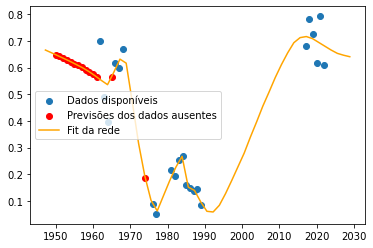

In [6]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

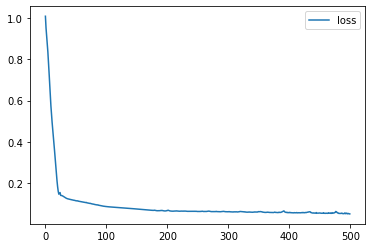

In [9]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [7]:
#Lista de anos sem buracos normalizada e sua predição      (para poder me referir por indices)

anos = np.arange(1950,np.max(anos_para_prever)+1)
anos_norm = (anos-ano_mean)/ano_std
prev_continua = model.predict(anos_norm)*prop_std + prop_mean

for i in range(len(prev_continua)):
    if prev_continua[i]<0:
        prev_continua[i]=0
    if prev_continua[i]>=1:
        prev_continua[i]=1

#Trazendo valores previstos para TOTAL_CRUSTACEOS_M (sem Camarao_art_ind de 50 a 54) (sem Camarao_art_ind e Lagosta art_ind de 55 a 74)
df_prev_M = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Lagosta/Previsão TOTAL_CRUSTACEOS_M_sem_Cam_Lag.xlsx')
df_prev_M = df_prev_M.replace(0,np.nan)


df_preenchido = df[['Ano','Caran_uca_art']]
for i in range(len(prev_continua)):
    if pd.isnull(df.loc[i,'Caran_uca_art'])==True:
      df_preenchido.loc[i,'Caran_uca_art']=df_prev_M.loc[i,'TOTAL_CRUSTACEOS_M']*prev_continua[i]

df_preenchido = df_preenchido.loc[:,:]
with pd.option_context('display.max_rows', None,):
    print(df_preenchido)


#Planilha com os dados preenchidos
df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Caran_uca_art/Previsão Caran_uca_art_1950-1974.xlsx')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
     Ano  Caran_uca_art
0   1950     264.230225
1   1951     244.806183
2   1952     225.494751
3   1953     196.719849
4   1954     172.259491
5   1955     202.167358
6   1956     145.555679
7   1957     105.320923
8   1958     131.485672
9   1959     201.166504
10  1960     116.676819
11  1961      83.926636
12  1962     174.000000
13  1963     207.000000
14  1964     114.000000
15  1965     157.168457
16  1966     122.000000
17  1967     162.000000
18  1968     125.000000
19  1969      14.509546
20  1970            NaN
21  1971            NaN
22  1972            NaN
23  1973            NaN
24  1974            NaN
25  1975            NaN
26  1976      22.000000
27  1977      32.000000
28  1978            NaN
29  1979      42.000000
30  1980      34.000000
31  1981      35.000000
32  1982      46.000000
33  1983      70.000000
34  1984      60.000000
35  1985      54.000000
36  1986      42.000000
37  1987      57.000000
38  1988      64.000000
39

In [8]:
#TOTAL_CRUSTACEOS_M sem o que já foi para Camarao_art_ind, Lagosta_art_ind, Caran_uca_art
TOTAL_CRUSTACEOS_M_sem_Cam_Lag_uca = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Lagosta/Previsão TOTAL_CRUSTACEOS_M_sem_Cam_Lag.xlsx')
for i in range(len(prev_continua)):
    TOTAL_CRUSTACEOS_M_sem_Cam_Lag_uca.loc[i,'TOTAL_CRUSTACEOS_M'] -= df_prev_M.loc[i,'TOTAL_CRUSTACEOS_M']*prev_continua[i]

with pd.option_context('display.max_rows', None,):
   print(TOTAL_CRUSTACEOS_M_sem_Cam_Lag_uca)

TOTAL_CRUSTACEOS_M_sem_Cam_Lag_uca.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Caran_uca_art/Previsão TOTAL_CRUSTACEOS_M_sem_Cam_Lag_uca.xlsx')

    Unnamed: 0   Ano  TOTAL_CRUSTACEOS_M
0            0  1950          143.617188
1            1  1951          136.851410
2            2  1952          129.619507
3            3  1953          116.277954
4            4  1954          104.721222
5            5  1955          126.646118
6            6  1956           93.932114
7            7  1957           70.017242
8            8  1958           90.418839
9            9  1959          143.323059
10          10  1960           86.414993
11          11  1961           64.765076
12          12  1962          130.446289
13          13  1963          145.378769
14          14  1964          138.939728
15          15  1965          120.727234
16          16  1966           90.021942
17          17  1967           85.218109
18          18  1968           35.219086
19          19  1969            9.366522
20          20  1970                 NaN
21          21  1971                 NaN
22          22  1972                 NaN
23          23  

In [13]:
#Planilha com previsões para Siri_azul_art_ind (o que sobrou)
df_Siri_azul_art_ind = df[['Ano','Siri_azul_art_ind']]
for i in range(len(df['Ano'])):
    if i+1950 in anos_para_prever:
        df_Siri_azul_art_ind.loc[i,'Siri_azul_art_ind'] = TOTAL_CRUSTACEOS_M_sem_Cam_Lag_uca.loc[i,'TOTAL_CRUSTACEOS_M']
with pd.option_context('display.max_rows', None,):
   print(df_Siri_azul_art_ind)

df_Siri_azul_art_ind.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Siri_azul/Desagregação Siri_azul_art_ind 1950-1974.xlsx')

     Ano  Siri_azul_art_ind
0   1950         143.617188
1   1951         136.851410
2   1952         129.619507
3   1953         116.277954
4   1954         104.721222
5   1955         126.646118
6   1956          93.932114
7   1957          70.017242
8   1958          90.418839
9   1959         143.323059
10  1960          86.414993
11  1961          64.765076
12  1962          75.000000
13  1963         217.000000
14  1964         175.000000
15  1965         120.727234
16  1966          76.000000
17  1967         109.000000
18  1968          62.000000
19  1969                NaN
20  1970                NaN
21  1971                NaN
22  1972                NaN
23  1973                NaN
24  1974                NaN
25  1975                NaN
26  1976         222.000000
27  1977         584.000000
28  1978                NaN
29  1979                NaN
30  1980                NaN
31  1981                NaN
32  1982                NaN
33  1983                NaN
34  1984            